In [6]:
import matplotlib.pyplot as plt
from scipy.sparse import rand
from tqdm import tqdm
import time
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings("ignore")

from prox import *
from other_func import *
from Algo import *

\begin{equation}
\min_{\mathbb{x}\in\mathbb{R}^n} \frac12\|A\mathbb{x}-\mathbb{b}\|_2^2+\lambda P_{\sigma}(\mathbb{x})\tag{17}
\end{equation}

The convergence of ISTA has been well studied in [47], when the penalty term $P(x)$ is
 a $\rho$ weakly convex penalty function, i.e.,  there exist $\rho\geq 0$ such that
$P(\mathbb{x})+\frac{\rho}{2}\|\mathbb{x}\|_2^2$ is convex [47, Definition 1].
Obviously,  the function $\lambda P_{\sigma}$ is $\rho$-weakly convex function for any $\rho\ge\frac{\lambda}{\sigma^2}$ \cite[Table 1]{Chen2014}. Denote the minimum and maximum eigenvalue of $A^{\top}A$ by $\nu_{\min}(A^{\top}A)$ and $\nu_{\max}(A^{\top}A)$, respectively. Associated with [47, Proposition 4], when
 $\frac{\lambda}{\sigma^2}\le \rho\le\nu_{\min}(A^{\top}A)$, the optimal solution set of (17) is non-empty. Moreover, when $0<\mu<\frac{2}{\nu_{\max}(A^{\top}A) +\rho}$, the sequence $\{\mathbb{x}^l:l\in\mathbb{N}\}$ in (16) converges to a minimizer of (17).

## Data preparation

In [7]:
# create DCT matrix  F=3
m = 128
n = 1024
A = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        A[i][j] = 1/np.sqrt(m)*np.cos(2*(j-1)*np.pi*np.random.uniform(0, 1)/3)  #F=3
print('before normalization:',1/np.linalg.norm(A,2)**2)
# normalize columns of matrix X
A = normalize(A, axis=0, norm='l2')
print('after normalization:',1/np.linalg.norm(A,2)**2)
corr = A.T.dot(A)
for i in range(1024):
    corr[i][i] = 0

print('coherence:',abs(corr).max())

before normalization: 0.13922410582432254
after normalization: 0.06977010788402101
coherence: 0.6610155963848524


In [8]:
e,v = np.linalg.eig(A.T.dot(A))
maxiter = 20000
error = 1e-5
k_list = np.linspace(4,60,15)
x_index = [i for i in range(n)]

## A recovery instance

using $\lambda = 0.02$, $\sigma = 2$, $\mu = 0.99\mu_{max}$, $k=45$

Running time: 8.5625
relative error: 0.007482801009789256


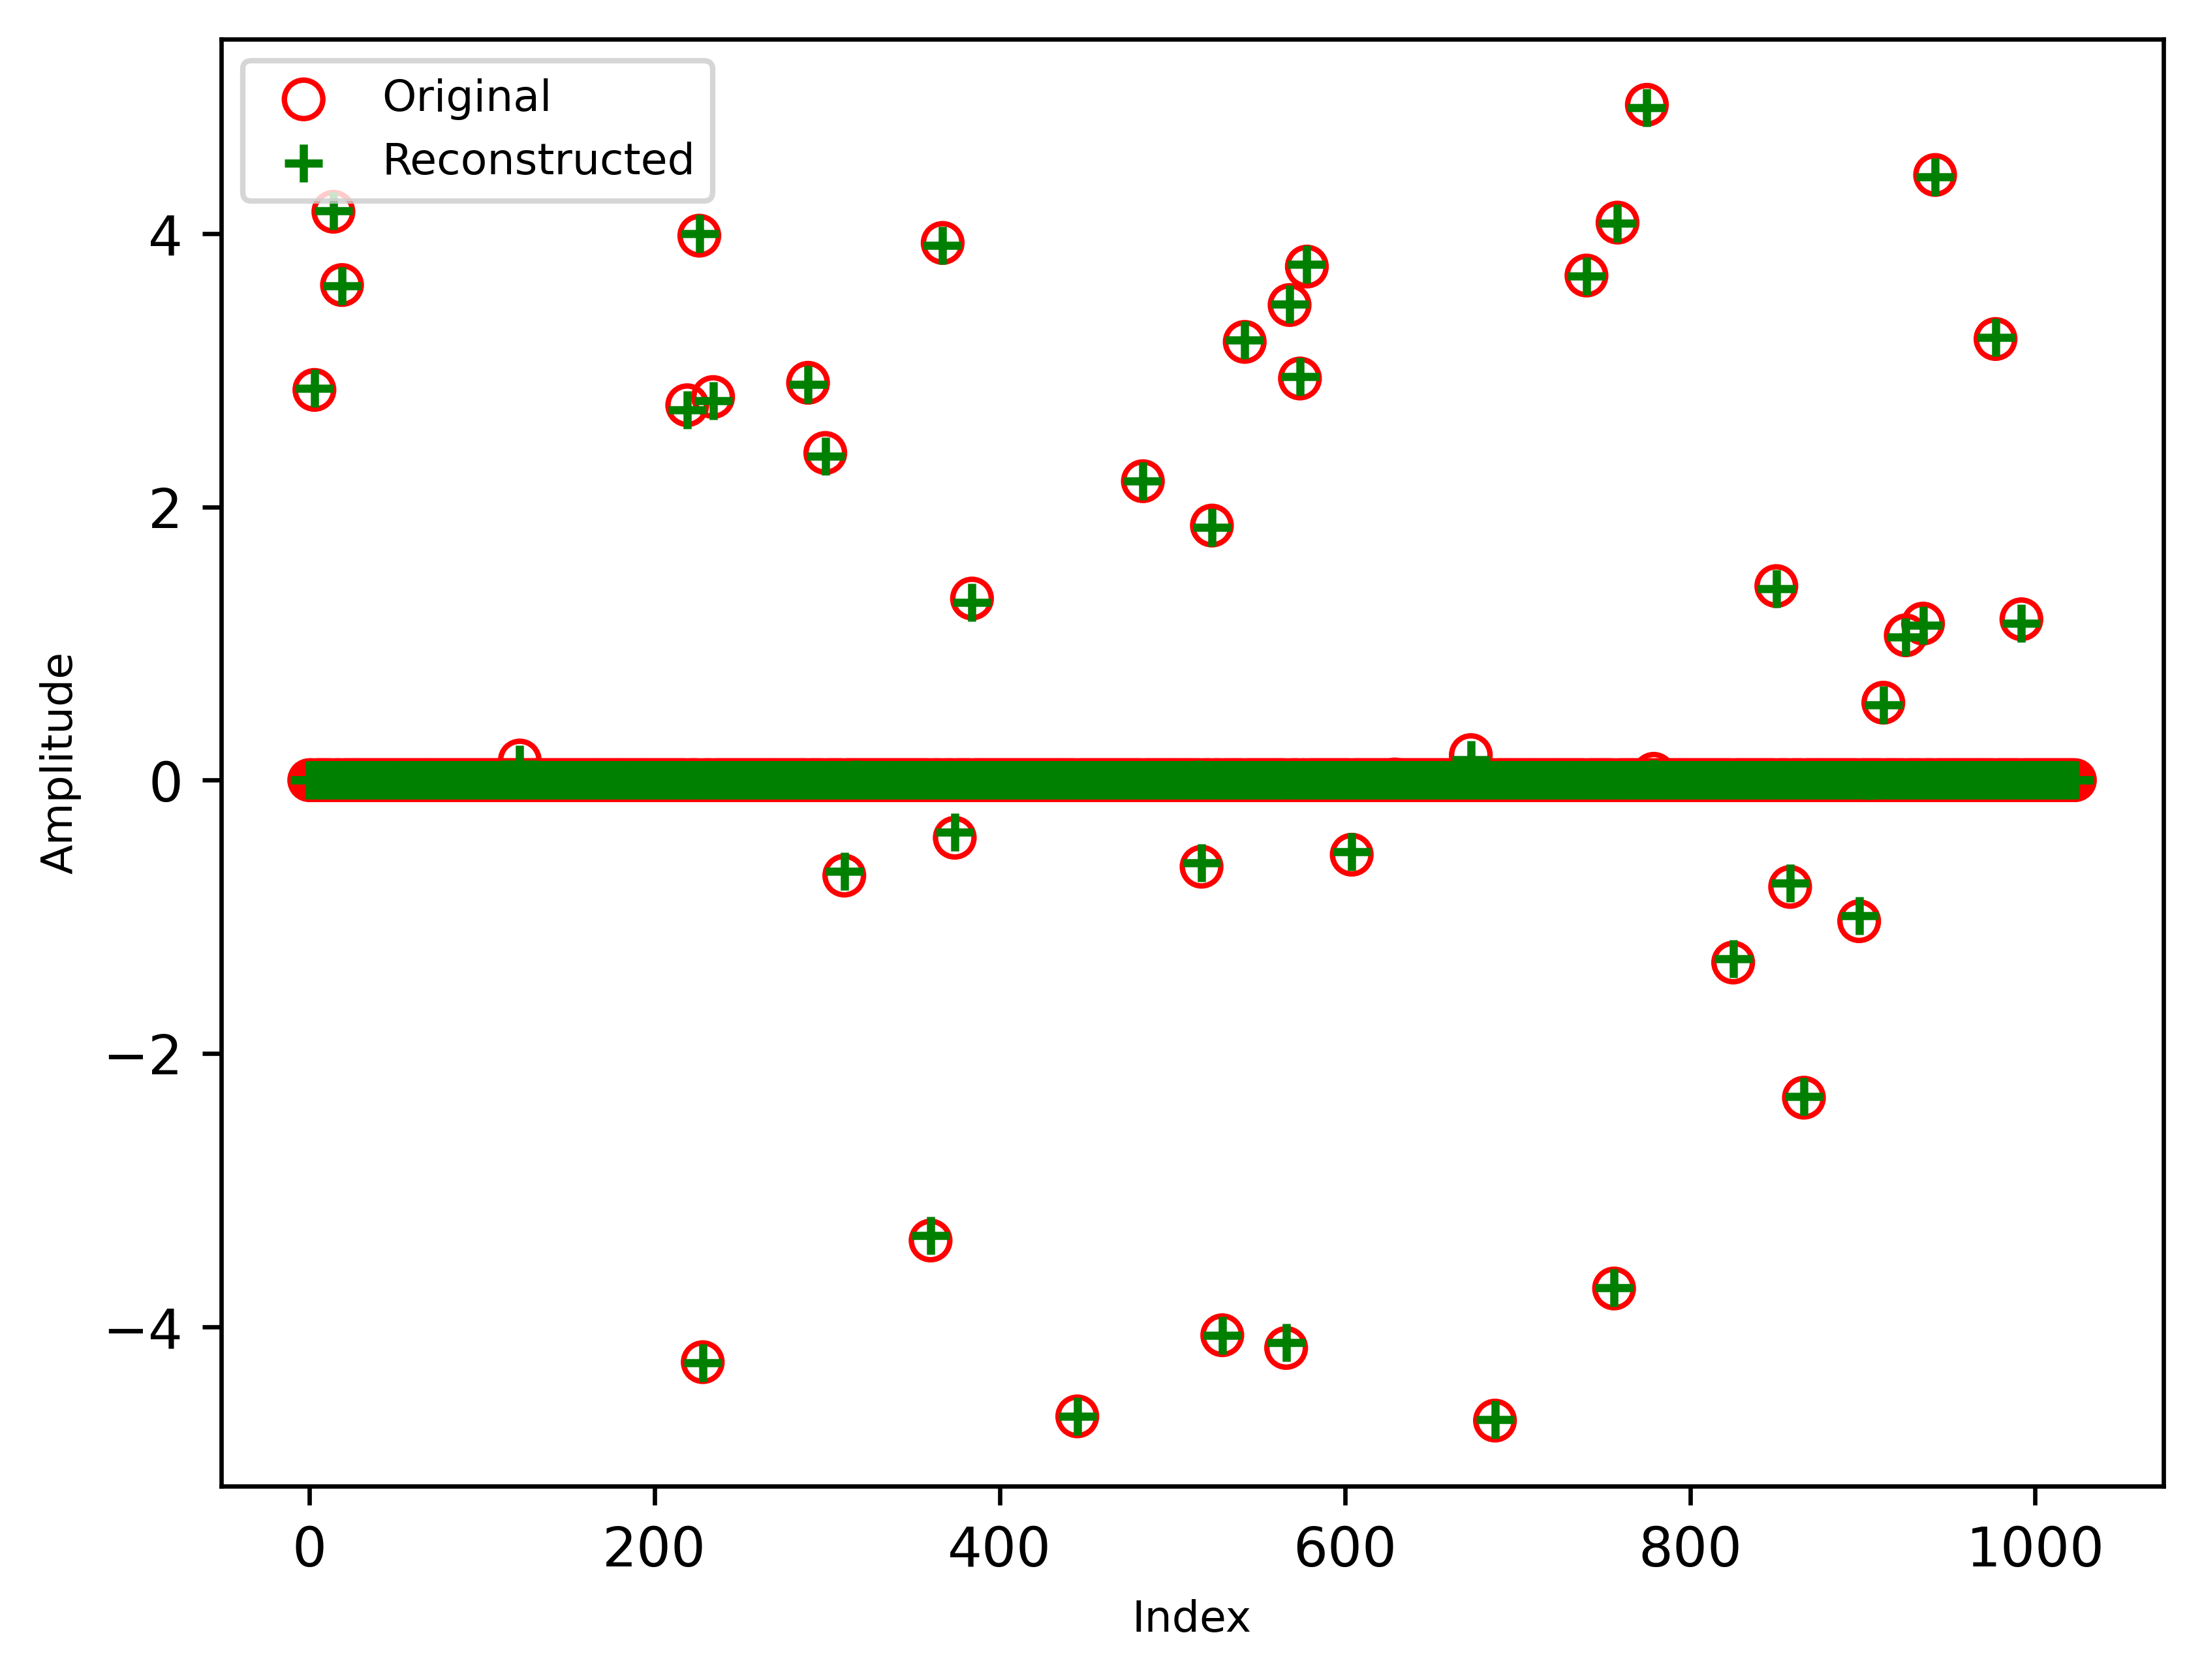

In [9]:
k = 45
Lambda = 0.05
sigma = 2

L=np.linalg.norm(A,2)**2
mu = 0.99*2/(L+Lambda/sigma**2)
for ww in range(100):
    x_true = rand(n,1,k/n).toarray()
    x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
    b = A.dot(x_true)
    b_noise = b
    Ab = A.T.dot(b_noise)
    AA = A.T.dot(A)
    
    t0 = time.process_time()
    temp = mu*Lambda/sigma**2
    if temp<=1:
        x,i=ISTA(A, b, mu, shrinkage_PiE_soft, sigma, Lambda, maxiter,error)
    else:
        x,i=ISTA(A, b, mu, PiEProximalbyLambertWThreshold, sigma, Lambda, maxiter,error)
    if np.linalg.norm(x-x_true)/np.linalg.norm(x_true)<0.01:
        print("Running time:",time.process_time() - t0)
        print('relative error:',np.linalg.norm(x-x_true)/np.linalg.norm(x_true))
        plt.figure()
        plt.scatter(x_index,x_true,color='none',marker='o' ,label='Original',edgecolors='r', s=50)
        plt.rcParams['figure.dpi'] = 600 #分辨率
        plt.scatter(x_index,x,marker='+',label='Reconstructed',color='g',s=50)
        plt.xlabel('Index',fontsize=8)
        plt.ylabel('Amplitude',fontsize=8)
        plt.legend(loc='upper left',fontsize = 8) 
        plt.show()
        break

## Comparison of 11 Non-Convex Penalty Functions without noise

### under $0.99*\mu_{max}$.



\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|} \hline
Penalties & PiE &Log & CaP & TL1 & SCAD & MCP & \ell_0 & \ell_1 &\ell_{1/2} &\ell_1-\ell_2 &\ell_1/\ell_2 \\ \hline
 &\lambda=0.05  &\lambda=0.02  &\lambda=0.02  &\lambda=0.02  &\lambda=0.2  &\lambda=0.2  &\lambda=0.9 &\lambda=0.02   &\lambda=0.1 &\lambda=0.01 &\lambda=0.01\\  
Parameters  &\sigma=2  &a=1  &a=1 &a=2 &a=20  &a=19  & -  & -   & - &a=1 & -\\  
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{\lambda}{\sigma^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{\lambda}{a^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{2(a+1)\lambda}{a^2}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{1}{a-1}}
           &\mu=0.5\!\frac{2}{\nu_{\max}+\frac{1}{a}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}}
&\mu=0.5\!\frac{2}{\nu_{\max}+2a}
&\mu=0.5\!\frac{2}{\nu_{\max}}
\\ \hline
\end{array}


In [10]:
shrinkage_list = [_,_,_,shrinkage_TL1,shrinkage_hard,shrinkage_soft,shrinkage_half,shrinkage_scad,shrinkage_mcp,shrinkage_l1_2,shrinkage_l1overl2]
#               PiE   Log    Cap   TL1   hard  soft   half  scad   mcp   L1-L2    L1/L2
lambda_list = [0.05, 0.02, 0.02 , 0.02,  0.9 , 0.01,   0.1 , 0.2,  0.2 , 0.01 ,  0.2 ]
a_list      = [ 2  ,   1 ,   1  ,  2  ,   0  ,   0 ,   0   , 20 ,  19  ,  1   ,   0  ]
mu_ = 0.99

mu_pie = mu_*(2/(max(e).real+lambda_list[0]/(a_list[0]**2)))
mu_scad= mu_*(2/(max(e).real+1/(a_list[7]-1)))
mu_mcp = mu_*(2/(max(e).real+1/(a_list[8])))
mu_log = mu_*(2/(max(e).real+lambda_list[1]/(a_list[1]**2)))
mu_tl1 = mu_*(2/(max(e).real+2*(a_list[3]+1)*lambda_list[3]/(a_list[3]**2)))
mu_L1_L2 = mu_*(2 /( max(e).real+2*a_list[9]))
mu     = mu_*(2 / max(e).real)

mu_list = [mu_pie,mu_log,mu,mu_tl1,mu,mu,mu,mu_scad,mu_mcp,mu_L1_L2,mu]
k_list = np.linspace(4,60,15)
x_index = [i for i in range(n)]

avgtime_99 = np.zeros((len(k_list),len(shrinkage_list)))
success_99 = np.zeros((len(k_list),len(shrinkage_list)))
numiter_99 = np.zeros((len(k_list),len(shrinkage_list)))
for index_k, k in enumerate(k_list):
    p = k/n
    
    total_time = np.zeros((1,len(shrinkage_list)))
    total_num = np.zeros((1,len(shrinkage_list)))
    for j in tqdm(range(100)):
        x_true = rand(n,1,p).toarray()
        x_true[x_true != 0 ] = 10*(x_true[x_true != 0 ]-0.5)
        b = A.dot(x_true)
        
        #PiE
        t0 = time.process_time()
        temp = mu_pie*lambda_list[0]/a_list[0]**2
        if temp<=1:
            x,num=ISTA(A,b,mu_list[0],shrinkage_PiE_soft,a_list[0],lambda_list[0],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[0],PiEProximalbyLambertWThreshold,a_list[0],lambda_list[0],maxiter,error)
        if Error(x,x_true)<0.01:
            success_99[index_k][0] += 0.01
        total_time[0][0] += time.process_time()-t0
        total_num[0][0] += num
        
        #Log
        t0 = time.process_time()
        if np.sqrt(lambda_list[1])<=a_list[1]:
            x,num=ISTA(A,b,mu_list[1],shrinkage_log_soft,a_list[1],lambda_list[1],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[1],shrinkage_log_hard,a_list[1],lambda_list[1],maxiter,error) 
        if Error(x,x_true)<0.01:
            success_99[index_k][1] += 0.01
        total_time[0][1] += time.process_time()-t0
        total_num[0][1] += num
        
        #Cap
        t0 = time.process_time()
        if lambda_list[2]<=2*a_list[2]:
            x,num=ISTA(A,b,mu_list[2],shrinkage_CaP_soft,a_list[2],lambda_list[2],maxiter,error)
        else:
            x,num=ISTA(A,b,mu_list[2],shrinkage_CaP_hard,a_list[2],lambda_list[2],maxiter,error)
        if Error(x, x_true)<0.01:
            success_99[index_k][2] += 0.01
        total_time[0][2] += time.process_time()-t0 
        total_num[0][2] += num
        
        for i in range(3,11):
            t0 = time.process_time()
            x,num=ISTA(A,b,mu_list[i],shrinkage_list[i],a_list[i],lambda_list[i],maxiter,error)
            if Error(x, x_true)<0.01:
                success_99[index_k][i] += 0.01
            total_time[0][i] += time.process_time()-t0 
            total_num[0][i] += num
    avgtime_99[index_k] = total_time/100
    numiter_99[index_k] = total_num/100

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [54:18<00:00, 32.59s/it]


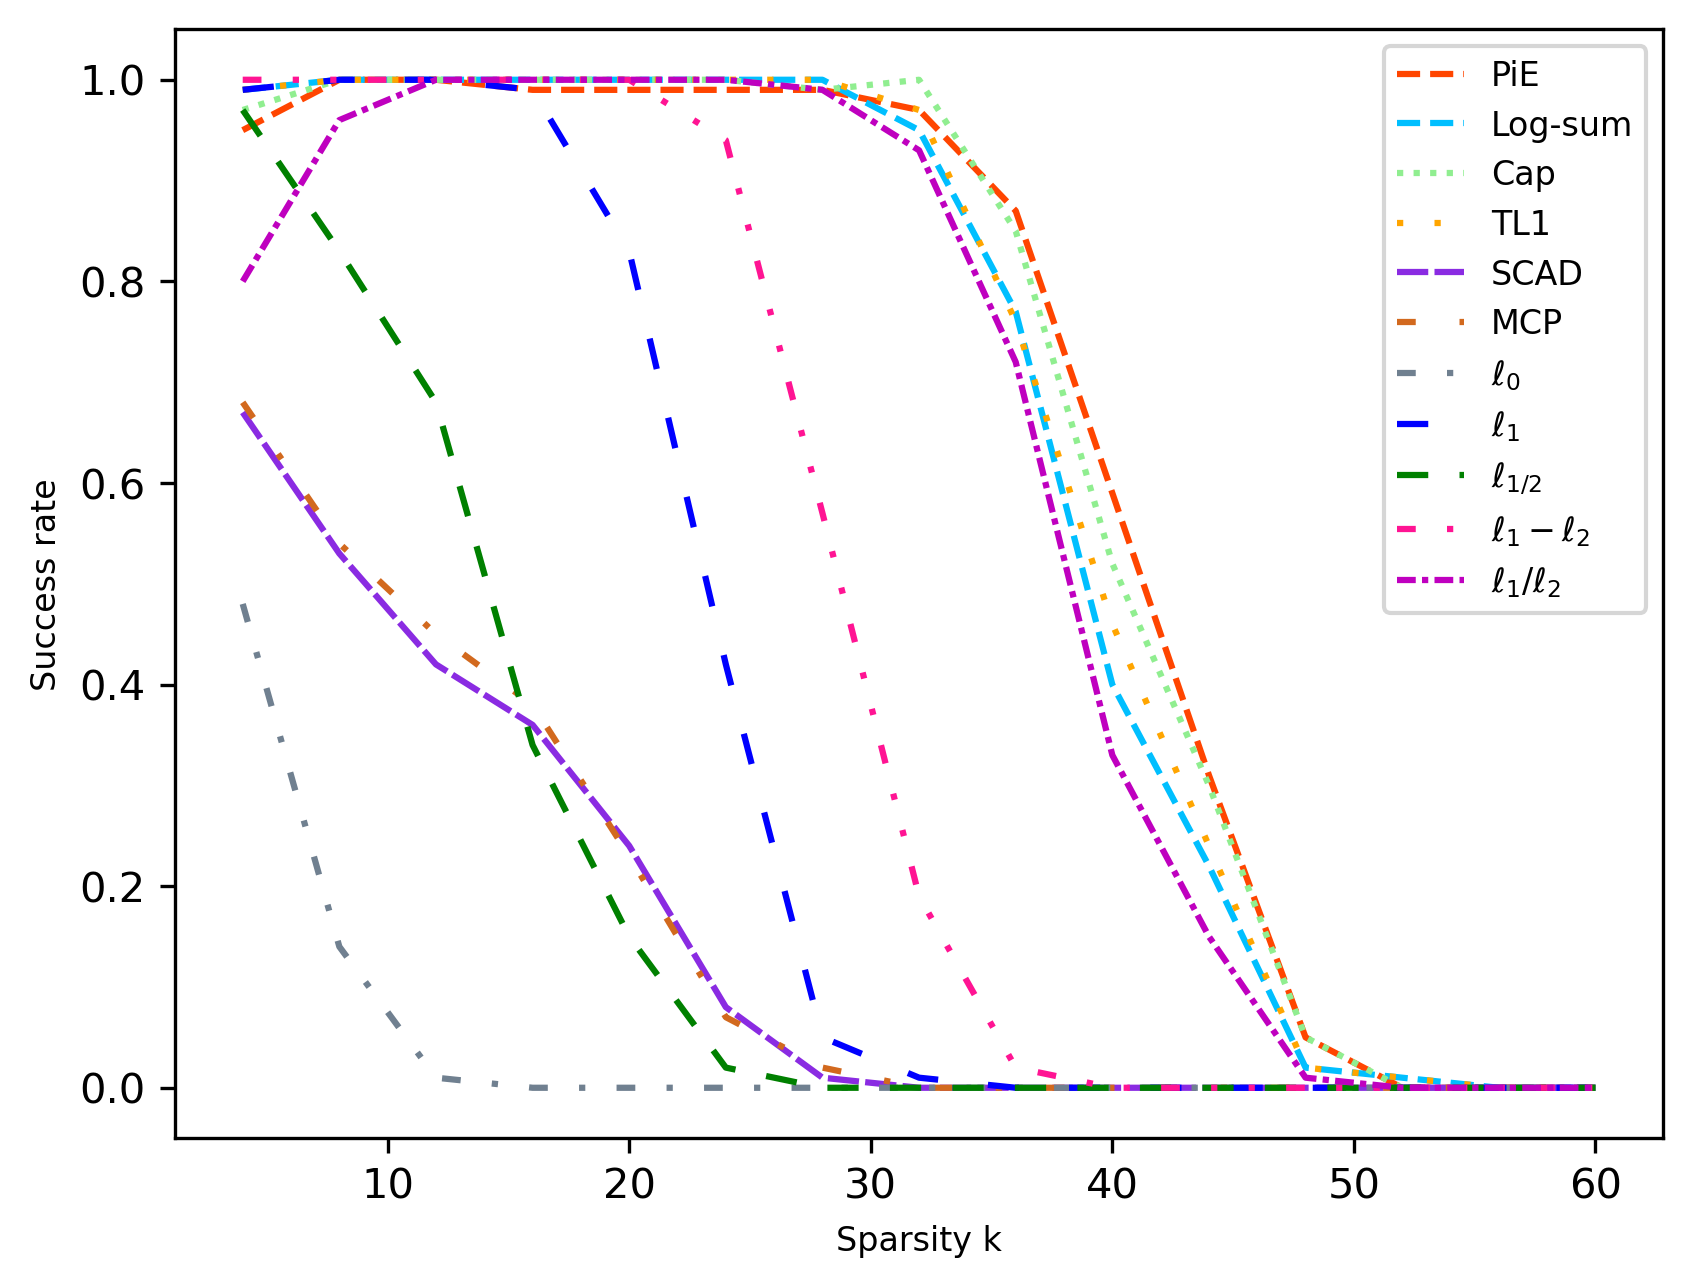

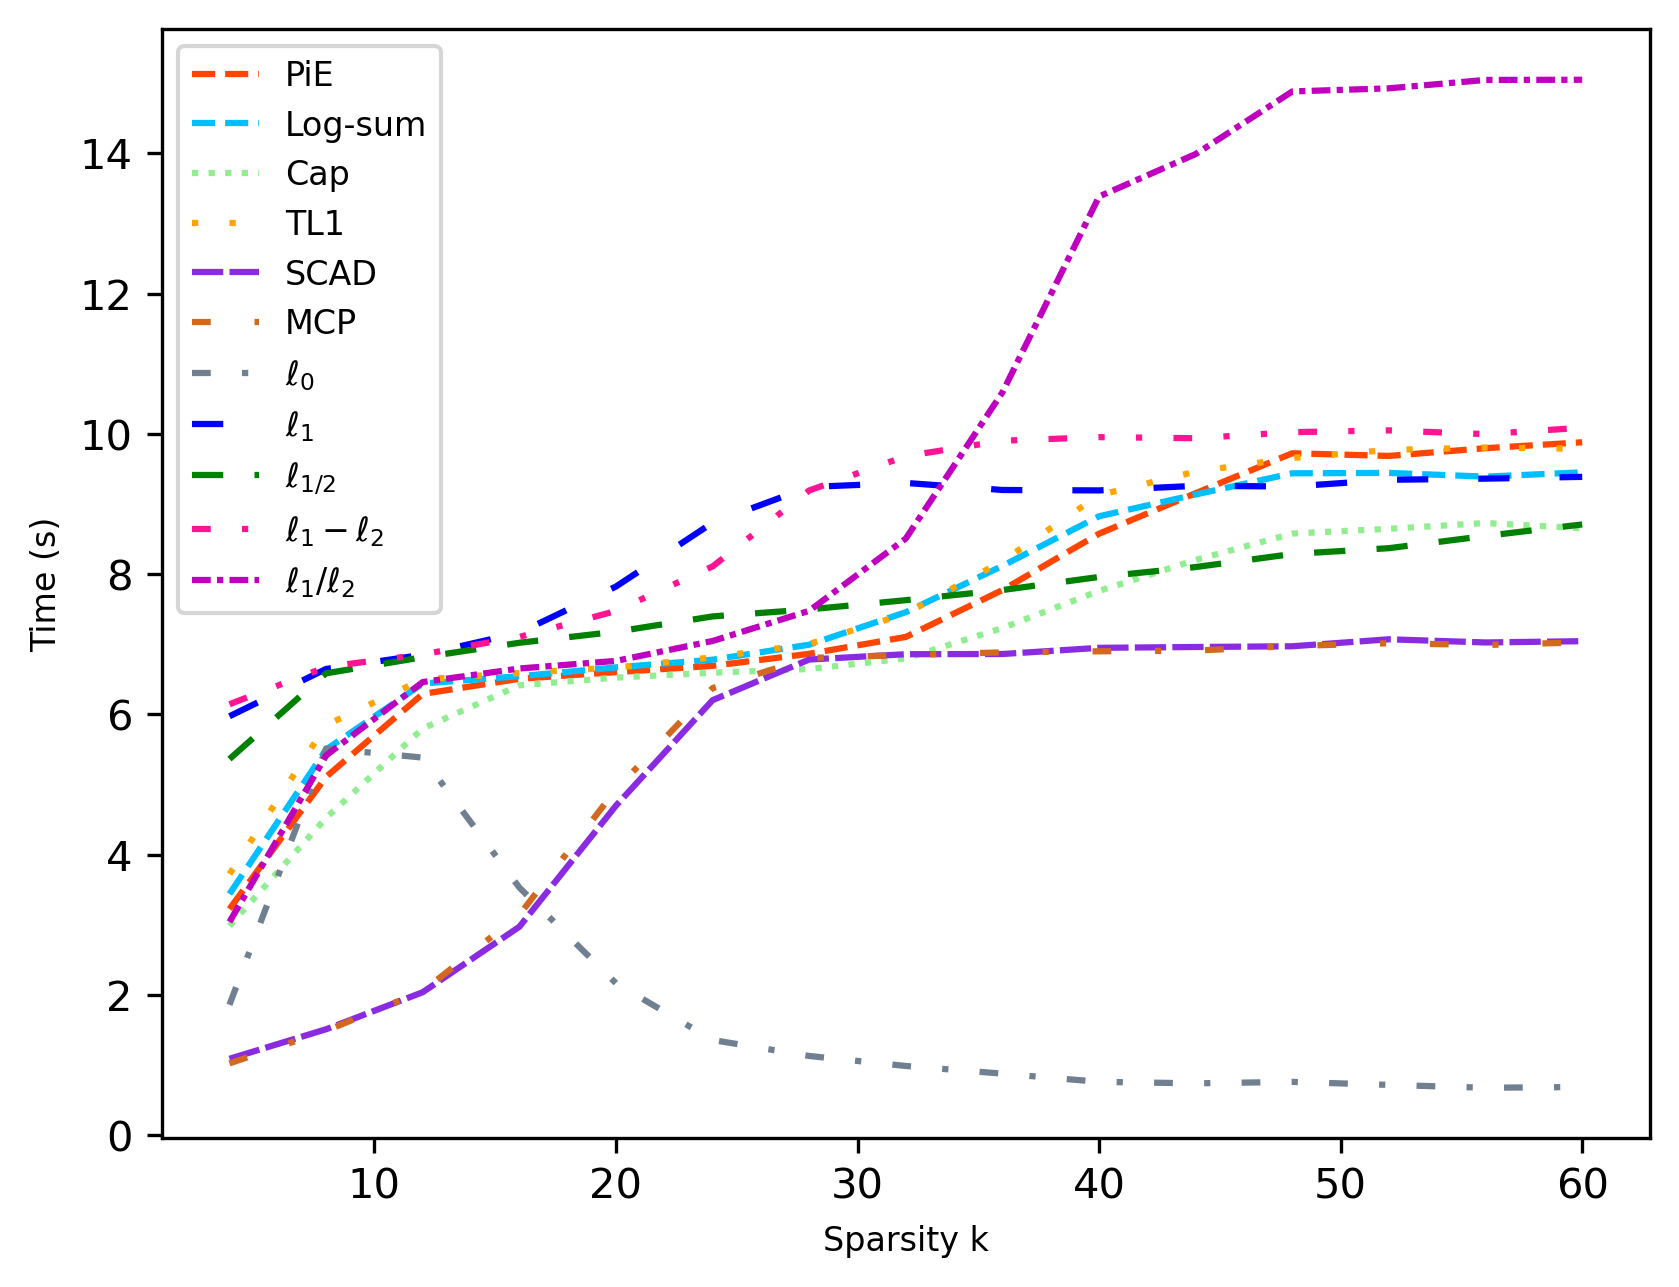

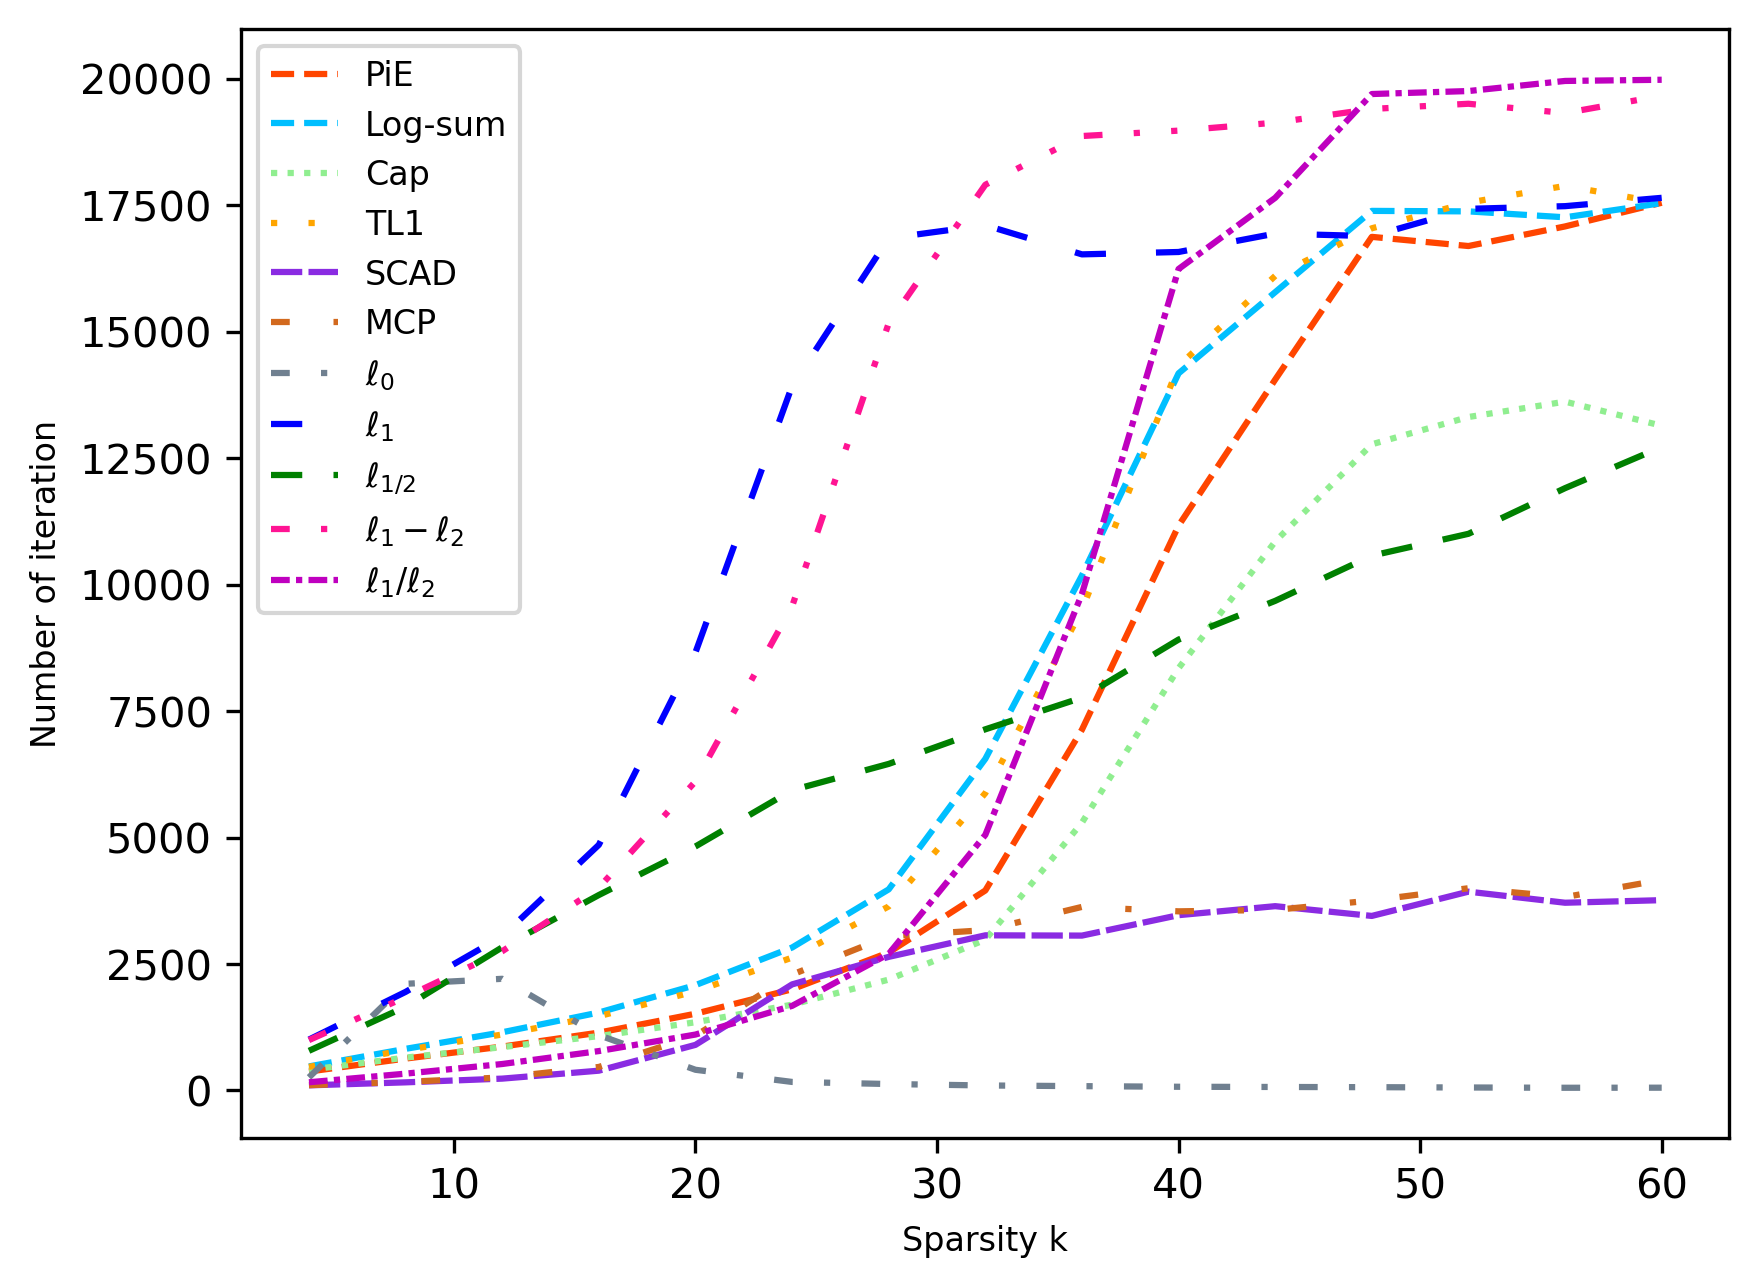

In [11]:
plt.rcParams['figure.dpi'] = 300 #分辨率
color_list = ['orangered','deepskyblue','lightgreen','orange','slategrey','blue','green',
              'blueviolet','chocolate','deeppink','m']
label_list = ['PiE','Log-sum','Cap','TL1','$\ell_0$','$\ell_1$','$\ell_{1/2}$','SCAD','MCP','$\ell_1-\ell_2$','$\ell_1/\ell_2$']
#mark_list = [None,None,None,None,None,None,None,None,None,None,None]


from collections import OrderedDict
# '-'       solid line style
# '--'      dashed line style
# '-.'      dash-dot line style
# ':'       dotted line style
linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 8))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 7, 1, 7))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 8, 1,8, 1, 8))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
linestyle_list=['--','--',':',linestyles_dict['dotted'],linestyles_dict['dashdotted'],
                linestyles_dict['loosely dashed'],linestyles_dict['dashed'],linestyles_dict['densely dashed'],
                linestyles_dict['loosely dashdotted'],linestyles_dict['dashdotdotted'],linestyles_dict['densely dashdotted']]



plt.figure()
for i in [0,1,2,3,7,8,4,5,6,9,10]:
    plt.plot(k_list, success_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle=linestyle_list[i])
plt.ylabel('Success rate',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.savefig('F3_penalty_rate.png')
plt.show()

plt.figure()
for i in [0,1,2,3,7,8,4,5,6,9,10]:
    plt.plot(k_list, avgtime_99[:,i],label=label_list[i],color=f'{color_list[i]}', linestyle=linestyle_list[i])
plt.ylabel('Time (s)',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.savefig('F3_penalty_time.png')
plt.show()

plt.figure()
for i in [0,1,2,3,7,8,4,5,6,9,10]:
    plt.plot(k_list, numiter_99[:,i],label=label_list[i],color=f'{color_list[i]}',linestyle=linestyle_list[i])
plt.ylabel('Number of iteration',fontsize =8)
plt.xlabel("Sparsity k",fontsize =8)
plt.legend(fontsize =8)
plt.savefig('F3_penalty_iter.png')
plt.show()

In [12]:
import pandas as pd
pd.DataFrame(success_99).to_excel('./pic/F3/success_99.xlsx')
pd.DataFrame(avgtime_99).to_excel('./pic/F3/avgtime_99.xlsx')
pd.DataFrame(numiter_99).to_excel('./pic/F3/numiter_99.xlsx')